In [325]:
import os
import rasterio
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage.transform import resize
import segmentation_models_pytorch as smp
import random
import json
from glob import glob
import os
import cv2

from tqdm import tqdm_notebook, tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# We write functions and classes for preprocessing and training the model - Прописываем функции и классы для предобработки и обучения модели

In [326]:
def print_geotiff_info(path):
    try:
        # Открываем файл
        with rasterio.open(path) as src:
            # Основные метаданные
            print(f"File Path: {path}")
            print(f"Driver: {src.driver}")
            print(f"Width: {src.width}")
            print(f"Height: {src.height}")
            print(f"Count (Bands): {src.count}")
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            print(f"Bounding Box: {src.bounds}")
            print(f"Datum: {src.dtypes}")

            # Информация по каждому каналу
            for i in range(1, src.count + 1):
                band = src.read(i)
                print(f"\nBand {i}:")
                print(f"  Data Type: {src.dtypes[i - 1]}")
                print(f"  Min Value: {band.min()}")
                print(f"  Max Value: {band.max()}")
                print(f"  Mean Value: {band.mean()}")
                print(f"  Standard Deviation: {band.std()}")

    except Exception as e:
        print(f'Error: {e}')


def visualize_rgb_geotiff(file_path, r_band, g_band, b_band, ik_band, mask_band, chanel=1):
    try:
        with rasterio.open(file_path) as src:
            num_bands = src.count
            print(f"Number of bands: {num_bands}")
            red = src.read(r_band)  # B02 - Blue
            green = src.read(g_band)  # B03 - Green
            blue = src.read(b_band)  # B04 - Red
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            if chanel == 1:
                photo = np.stack([red, green, blue], axis=-1)  # Отрисовка всего изображения
            elif chanel == 2:
                photo = np.stack([ik], axis=-1) # Отрисовка ИК-слоя изображения
            elif chanel == 3:
                photo = np.stack([mask], axis=-1)  # Отрисовка маски изображения
            photo = photo.astype(np.uint8)
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(photo)
            ax.axis('off')
            plt.show()
            return photo
    except Exception as e:
        print(f'Ошибка: {e}')


def get_rgb_geotiff(file_path, r_band, g_band, b_band, ik_band, mask_band, chanel=1):
    try:
        with rasterio.open(file_path) as src:
            red = src.read(r_band)  # B02 - Blue
            green = src.read(g_band)  # B03 - Green
            blue = src.read(b_band)  # B04 - Red
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            if chanel == 1:
                photo = np.stack([red, green, blue], axis=-1)  # Отрисовка всего изображения
            elif chanel == 2:
                photo = np.stack([ik], axis=-1) # Отрисовка ИК-слоя изображения
            elif chanel == 3:
                photo = np.stack([mask], axis=-1)  # Отрисовка маски изображения
            photo = photo.astype(np.uint8)
            return photo
    except Exception as e:
        print(f'Ошибка: {e}')


In [327]:
class SegmentationDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask_transform=None, random_params=None):
        self.dataframe = dataframe
        self.transform = transform
        self.mask_transform = mask_transform
        self.random_params = random_params

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = list(self.dataframe['img_path'])[idx]

        image = get_rgb_geotiff(img_path, 1, 2, 3, 4, 5, chanel=1)
        # image = np.repeat(image, 3, axis=2)
        image = np.clip(image.astype(float) * 3, 0, 255).astype(np.uint8)
        mask = get_rgb_geotiff(img_path, 1, 2, 3, 4, 5, chanel=3)
        
        # Apply transformations if random_params are provided
        if self.random_params:
            image = self.random_params.apply(image)
            mask = self.random_params.apply(mask, mask=True)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

In [328]:
class Metrics:
    @staticmethod
    def f1_score(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        return f1.item()

    @staticmethod
    def precision(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
        precision = tp / (tp + fp + 1e-6)
        return precision.item()
    
    @staticmethod
    def recall(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
        recall = tp / (tp + fn + 1e-6)
        return recall.item()

    @staticmethod
    def accuracy(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        correct = (y_true == y_pred).float().sum()
        accuracy = correct / y_true.numel()
        return accuracy.item()

    @staticmethod
    def matthews_corrcoef(y_true, y_pred, threshold=0.5, eps=1e-6):
        y_pred = (y_pred > threshold).float()
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        tp = (y_true * y_pred).sum().to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
        fp = (y_pred * (1 - y_true)).sum().to(torch.float32)
        fn = ((1 - y_pred) * y_true).sum().to(torch.float32)
        numerator = (tp * tn) - (fp * fn)
        denominator = torch.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = numerator / (denominator + eps)
        mcc_normalized = (mcc + 1) / 2
        return mcc_normalized.item()

# Data analysis - Анализ данных

In [329]:
data = {
    'img_path': [],
    'W': [],
    'H': []
}

for i in os.listdir('train'):
    for path_img in [f for f in os.listdir(f'train/{i}') if 'tiff' in f]:
        data['img_path'].append(f"train/{i}/{path_img}")
        with rasterio.open(f"train/{i}/{path_img}") as src:
            data['W'].append(src.width)
            data['H'].append(src.height)


data = pd.DataFrame(data)

In [330]:
data.describe()

W           H
count    21.000000   21.000000
mean    459.238095  329.904762
std     338.693800  207.766673
min     135.000000  106.000000
25%     249.000000  204.000000
50%     381.000000  257.000000
75%     592.000000  423.000000
max    1651.000000  992.000000

In [331]:
file_path = r'train\06\2021-06-03.tiff'
print_geotiff_info(file_path)

File Path: train\06\2021-06-03.tiff
Driver: GTiff
Width: 702
Height: 680
Count (Bands): 5
CRS: EPSG:4326
Transform: | 10.00, 0.00, 73.36|
| 0.00,-10.00, 55.30|
| 0.00, 0.00, 1.00|
Bounding Box: BoundingBox(left=73.35841, bottom=-6744.702852, right=7093.35841, top=55.297148)
Datum: ('float32', 'float32', 'float32', 'float32', 'float32')

Band 1:
  Data Type: float32
  Min Value: 6.0
  Max Value: 117.0
  Mean Value: 13.242181777954102
  Standard Deviation: 4.746762275695801

Band 2:
  Data Type: float32
  Min Value: 6.0
  Max Value: 116.0
  Mean Value: 17.403249740600586
  Standard Deviation: 5.346482276916504

Band 3:
  Data Type: float32
  Min Value: 4.0
  Max Value: 112.0
  Mean Value: 16.016992568969727
  Standard Deviation: 8.0848388671875

Band 4:
  Data Type: float32
  Min Value: 11.0
  Max Value: 145.0
  Mean Value: 62.35188293457031
  Standard Deviation: 12.316082000732422

Band 5:
  Data Type: float32
  Min Value: 0.0
  Max Value: 1.0
  Mean Value: 0.0070806099101901054
  Stand

Number of bands: 5


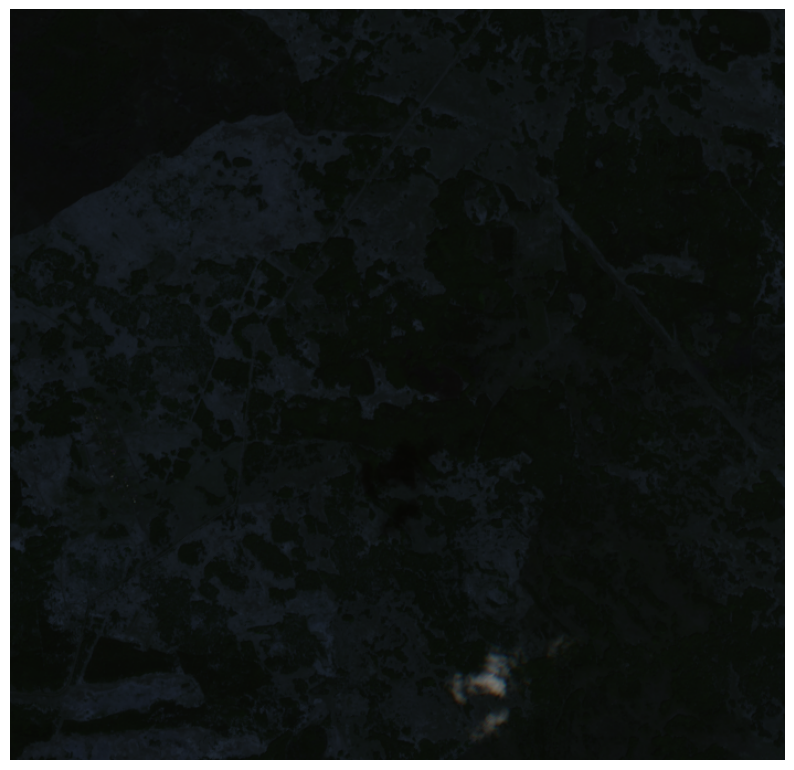

(680, 702, 3)

In [332]:
ch1 = visualize_rgb_geotiff(file_path, 1, 2, 3, 4, 5, chanel=1)
ch1.shape

Number of bands: 5


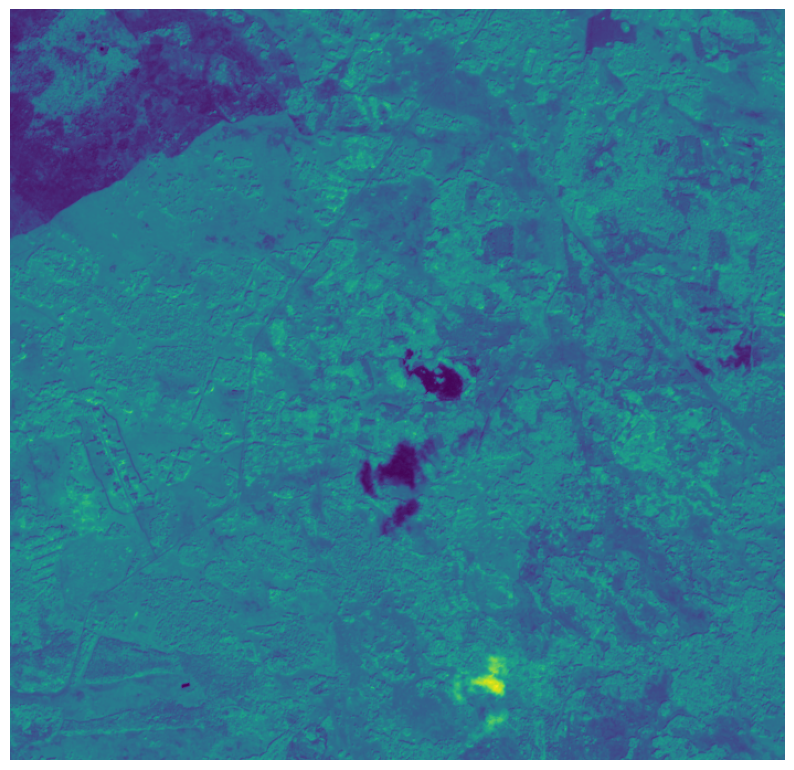

(680, 702, 1)

In [333]:
ch2 = visualize_rgb_geotiff(file_path, 1, 2, 3, 4, 5, chanel=2)
ch2.shape

Number of bands: 5


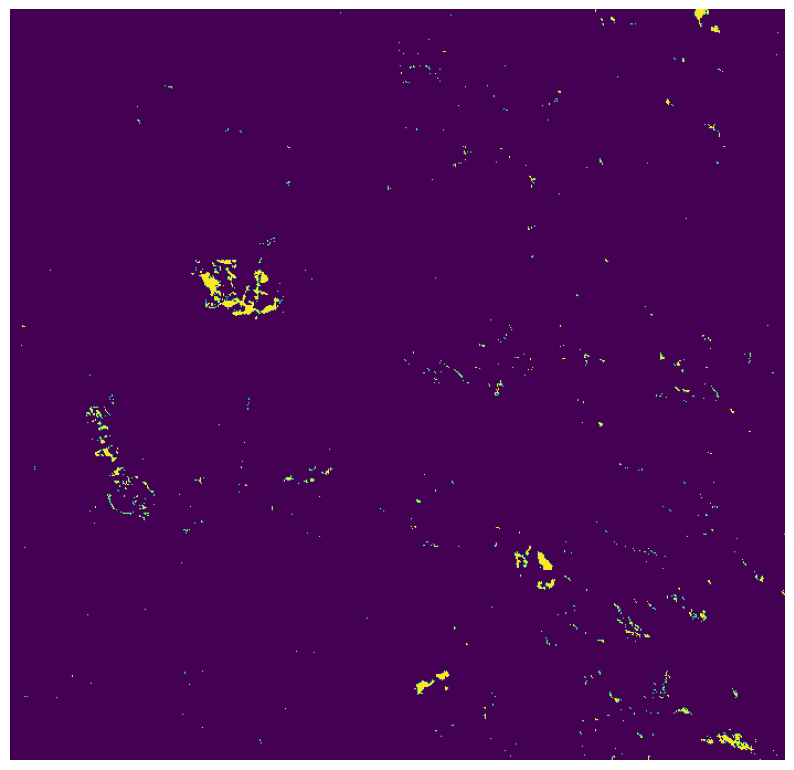

(680, 702, 1)

In [334]:
ch3 = visualize_rgb_geotiff(file_path, 1, 2, 3, 4, 5, chanel=3)
ch3.shape

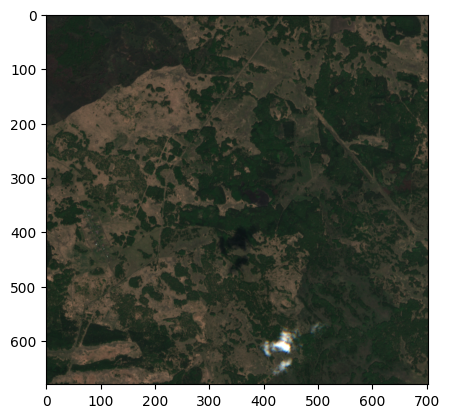

In [335]:
plt.imshow(np.clip(ch1.astype(float) * 3, 0, 255).astype(np.uint8)[:, :, ::-1])

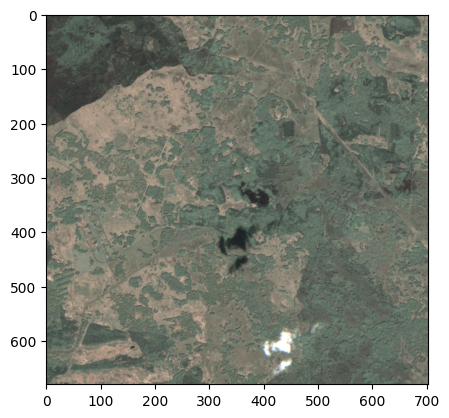

In [336]:
plt.imshow(np.clip((ch1.astype(float) * 3)[:, :, ::-1] + ch2.astype(float), 0, 255).astype(np.uint8))

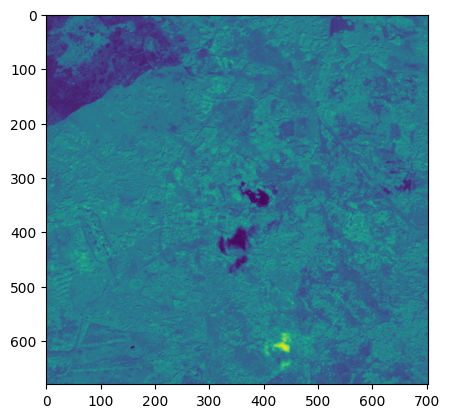

In [337]:
plt.imshow(ch2)

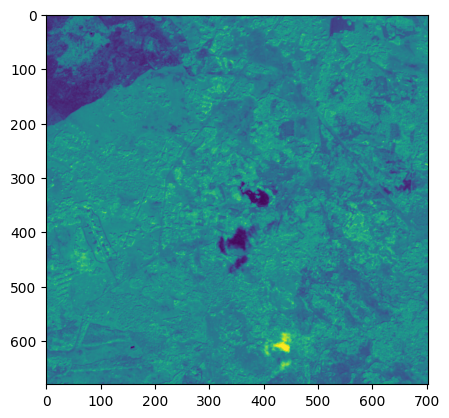

In [338]:
plt.imshow(np.clip(ch2.astype(float) * 2, 0, 255).astype(np.uint8))

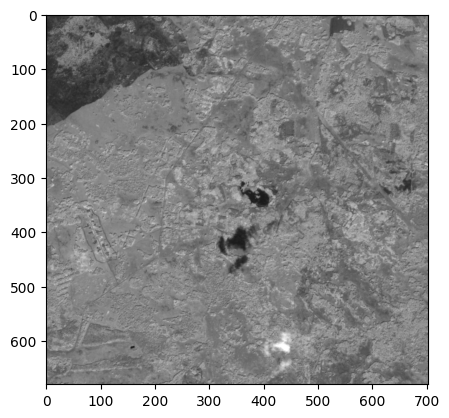

In [339]:
plt.imshow(np.repeat(np.clip(ch2.astype(float) * 2, 0, 255).astype(np.uint8), 3, axis=2))

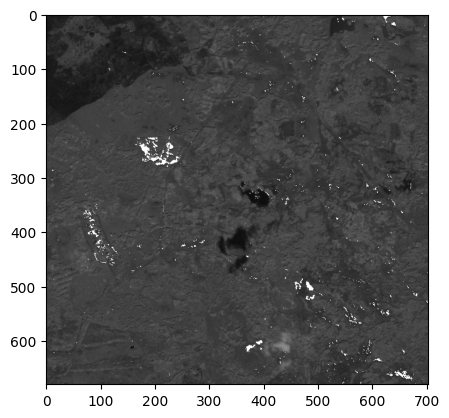

In [340]:
plt.imshow(np.repeat(np.clip(ch2.astype(float) + ch3.astype(float) * 255, 0, 255).astype(np.uint8), 3, axis=2) )

# Divide into training and validation set - Разделим на тренировочную и валидационную выборку

In [341]:
train = data.iloc[:15, :]
valid = data.iloc[15:, :]

In [351]:
class RandomParams:
    def __init__(self):
        self.params = {
            'horizontal_flip': random.choice([0, 1]),
            'vertical_flip': random.choice([0, 1]),
            'color_jitter': random.choice([0, 1]),
            'blur': random.choice([0, 1])
        }

    def apply(self, image, mask=False):
        if not mask:
            # Convert to PIL Image if it's a NumPy array
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # Image.fromarray(image.astype('uint8'), 'RGB')
            if self.params['horizontal_flip']:
                image = transforms.RandomHorizontalFlip(p=1)(image)
            if self.params['vertical_flip']:
                image = transforms.RandomVerticalFlip(p=1)(image)
            if self.params['color_jitter']:
                image = transforms.ColorJitter(brightness=0.5)(image)
            if self.params['blur']:
                image = transforms.GaussianBlur((3, 3))(image)
            image = np.array(image)
            image = cv2.resize(image, (160, 128))
            image = transforms.ToTensor()(image)
            return image
        else:
            if self.params['horizontal_flip']:
                image = np.fliplr(image)
            if self.params['vertical_flip']:
                image = np.flipud(image)
            image = cv2.resize(image, (160, 128))
            return torch.tensor(image, dtype=torch.float32).unsqueeze(0)

In [352]:
image_transform = transforms.Compose([
    transforms.Lambda(lambda x: Image.fromarray(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))),
    transforms.Lambda(lambda x: cv2.resize(np.array(x), (160, 128))),  # Используем cv2.resize
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Lambda(lambda mask: cv2.resize(mask, (160, 128))),  # Для маски используем интерполяцию NEAREST
    transforms.Lambda(lambda mask: torch.tensor(mask, dtype=torch.float32).unsqueeze(0))  # Преобразование маски в тензор
])

In [353]:
random_params = RandomParams()

In [354]:
train_dataset = SegmentationDataset(dataframe=train, random_params=random_params)
orig_train_dataset = SegmentationDataset(dataframe=train, transform=image_transform, mask_transform=mask_transform)
valid_dataset = SegmentationDataset(dataframe=valid, transform=image_transform, mask_transform=mask_transform)

batch_size = 5
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # num_workers=8)
orig_train_dataloader = DataLoader(orig_train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False) # num_workers=4)

C:\Users\Egor\AppData\Local\Temp\ipykernel_21548\4027607438.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Batch 1
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


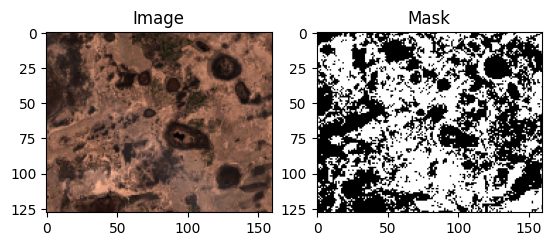

Batch 2
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


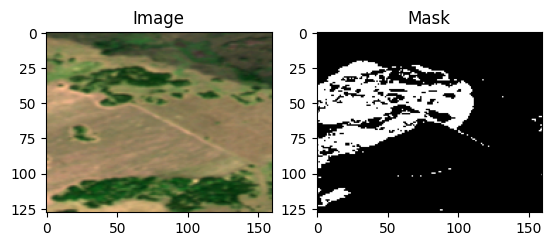

Batch 3
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


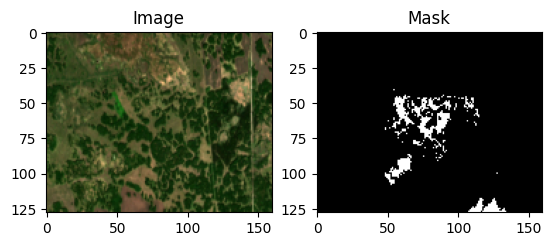

In [355]:
for batch_idx, (images, masks) in enumerate(train_dataloader):
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    # Отображение первого изображения и маски в батче
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # нормализация для отображения
    
    mask = masks[0].squeeze(0).cpu().numpy()
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    
    plt.show()
    if batch_idx == 4:
        break

Batch 1
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


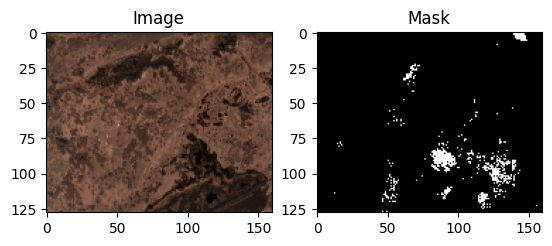

Batch 2
Images shape: torch.Size([1, 3, 128, 160])
Masks shape: torch.Size([1, 1, 128, 160])


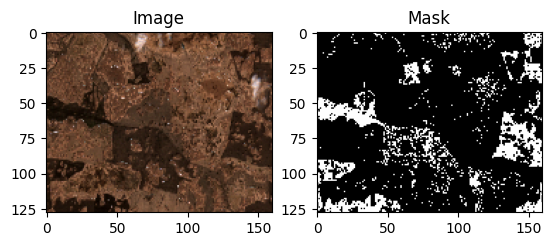

In [356]:
for batch_idx, (images, masks) in enumerate(valid_dataloader):
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    # Отображение первого изображения и маски в батче
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # нормализация для отображения
    
    mask = masks[0].squeeze(0).cpu().numpy()
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    
    plt.show()
    if batch_idx == 4:
        break

# Let’s initialize the model and write functions for training - С инициализируем модель и пропишим функции для обучения

In [357]:
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)
model = model.to(device)
optimizer = torch.optim.ASGD(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
loss_function = torch.nn.BCEWithLogitsLoss()

In [358]:
def train_one_epoch(data_loader, num_ep, metric_f: Metrics):
    global device, model, optimizer, loss_function
    model.train()
    total_loss = 0.0
    total_samples = 0
    metric_res = {
        'f1_score': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0,
        'mcc': 0.0
    }
    print(f'Epoch train: {num_ep + 1}')
    print('-----------------------------------')
    for batch_index, batch in enumerate(tqdm_notebook(data_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        
        batch_size = x_batch.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size
        
        output_sigmoid = torch.sigmoid(output)
        metric_res['f1_score'] += metric_f.f1_score(y_batch, output_sigmoid) * batch_size
        metric_res['precision'] += metric_f.precision(y_batch, output_sigmoid) * batch_size
        metric_res['recall'] += metric_f.recall(y_batch, output_sigmoid) * batch_size
        metric_res['accuracy'] += metric_f.accuracy(y_batch, output_sigmoid) * batch_size
        metric_res['mcc'] += metric_f.matthews_corrcoef(y_batch, output_sigmoid) * batch_size
        
        loss.backward()
        optimizer.step()
        
    avg_loss = total_loss / total_samples
    print(f'Loss train: {avg_loss}')
    metric_res = {i: metric_res[i] / total_samples for i in metric_res}
    for metric in metric_res:
        print(f'{metric}: {metric_res[metric]}')
    return avg_loss, metric_res


def validation_one_epoch(data_loader, metric_f: Metrics):
    global device, model, loss_function
    model.eval()
    total_loss = 0.0
    total_samples = 0
    metric_res = {
        'f1_score': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0,
        'mcc': 0.0
    }
    for batch_index, batch in enumerate(tqdm_notebook(data_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            
            batch_size = x_batch.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            output_sigmoid = torch.sigmoid(output)
            metric_res['f1_score'] += metric_f.f1_score(y_batch, output_sigmoid) * batch_size
            metric_res['precision'] += metric_f.precision(y_batch, output_sigmoid) * batch_size
            metric_res['recall'] += metric_f.recall(y_batch, output_sigmoid) * batch_size
            metric_res['accuracy'] += metric_f.accuracy(y_batch, output_sigmoid) * batch_size
            metric_res['mcc'] += metric_f.matthews_corrcoef(y_batch, output_sigmoid) * batch_size
            
    avg_loss = total_loss / total_samples
    print(f'Loss validation: {avg_loss}')
    metric_res = {i: metric_res[i] / total_samples for i in metric_res}
    for metric in metric_res:
        print(f'{metric}: {metric_res[metric]}')
    print('-----------------------------------')
    print()
    return avg_loss, metric_res


In [359]:
epoches = 32

train_losses = []
metric_res_train = {
    'f1_score': [],
    'precision': [],
    'recall': [],
    'accuracy': [],
    'mcc': []
}

valid_losses = []
metric_res_valid = {
    'f1_score': [],
    'precision': [],
    'recall': [],
    'accuracy': [],
    'mcc': []
}

best_metrics = {
    'f1_score': 0,
    'precision': 0,
    'recall': 0,
    'accuracy': 0,
    'mcc': 0
}
best_model_wts = 'model'
min_loss = 10 ** 9
step_flag = 3

for epoch in range(epoches):
    if epoch % step_flag == 0:
        losses_train_epoch, metric_res_train_epoch = train_one_epoch(orig_train_dataloader, epoch, Metrics)
        train_losses.append(losses_train_epoch)
        for i in metric_res_train_epoch:
            metric_res_train[i].append(metric_res_train_epoch[i])
    else:
        losses_train_epoch, metric_res_train_epoch = train_one_epoch(train_dataloader, epoch, Metrics)
        train_losses.append(losses_train_epoch)
        for i in metric_res_train_epoch:
            metric_res_train[i].append(metric_res_train_epoch[i])
    
    losses_val_epoch, metric_res_val_epoch = validation_one_epoch(valid_dataloader, Metrics)
    valid_losses.append(losses_val_epoch)
    for i in metric_res_val_epoch:
        metric_res_valid[i].append(metric_res_val_epoch[i])
    
    if any([best_metrics[i] <= metric_res_val_epoch[i] for i in metric_res_val_epoch]) and min_loss > losses_val_epoch:
        best_model_wts = model.state_dict()
        best_metrics = {i: metric_res_val_epoch[i] for i in metric_res_val_epoch}
        min_loss = losses_val_epoch
        print(f'Point, {best_metrics}, loss: {min_loss}')
    
    scheduler.step(losses_val_epoch)

Epoch train: 1
-----------------------------------


C:\Users\Egor\AppData\Local\Temp\ipykernel_21548\4119536274.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_index, batch in enumerate(tqdm_notebook(data_loader)):


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8510993917783102
f1_score: 0.150652344028155
precision: 0.09085050721963246
recall: 0.48288772503534955
accuracy: 0.40857747197151184
mcc: 0.47028077642122906


C:\Users\Egor\AppData\Local\Temp\ipykernel_21548\4119536274.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_index, batch in enumerate(tqdm_notebook(data_loader)):


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7566075722376505
f1_score: 0.12554131199916205
precision: 0.06994902963439624
recall: 0.7898271779219309
accuracy: 0.25698243578275043
mcc: 0.5001292328039805
-----------------------------------

Point, {'f1_score': 0.12554131199916205, 'precision': 0.06994902963439624, 'recall': 0.7898271779219309, 'accuracy': 0.25698243578275043, 'mcc': 0.5001292328039805}, loss: 0.7566075722376505
Epoch train: 2
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Egor\AppData\Local\Temp\ipykernel_21548\4027607438.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Loss train: 0.8420622746149699
f1_score: 0.1636185497045517
precision: 0.09657525767882665
recall: 0.5597307682037354
accuracy: 0.4153710901737213
mcc: 0.4873330394426982


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.8852033217748007
f1_score: 0.1282022421558698
precision: 0.07048375594119231
recall: 0.930019478003184
accuracy: 0.14056803037722906
mcc: 0.5028682251771291
-----------------------------------

Epoch train: 3
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8510673642158508
f1_score: 0.15806573132673898
precision: 0.09418183068434398
recall: 0.529901792605718
accuracy: 0.4116015632947286
mcc: 0.4802446961402893


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.9693623483181
f1_score: 0.12783163040876389
precision: 0.07026880234479904
recall: 0.9363191028436025
accuracy: 0.12890625
mcc: 0.5010201781988144
-----------------------------------

Epoch train: 4
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8368640343348185
f1_score: 0.16591095924377441
precision: 0.09878005584081014
recall: 0.5655120015144348
accuracy: 0.4186425705750783
mcc: 0.4908996323744456


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 1.013402948776881
f1_score: 0.12871151665846506
precision: 0.07092420198023319
recall: 0.9258721669514974
accuracy: 0.13994954278071722
mcc: 0.503314862648646
-----------------------------------

Epoch train: 5
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8380407691001892
f1_score: 0.1584263158341249
precision: 0.09780705409745376
recall: 0.5197580357392629
accuracy: 0.4195898473262787
mcc: 0.485747754573822


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 1.0047658383846283
f1_score: 0.12950470050175986
precision: 0.07185082137584686
recall: 0.8879508376121521
accuracy: 0.17932128657897314
mcc: 0.5061163008213043
-----------------------------------

Epoch train: 6
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8401397069295248
f1_score: 0.1558337608973185
precision: 0.0959861259907484
recall: 0.5578091144561768
accuracy: 0.4155566394329071
mcc: 0.4866548577944438


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.9665493667125702
f1_score: 0.1307152435183525
precision: 0.07329197352131207
recall: 0.829459140698115
accuracy: 0.24122721950213113
mcc: 0.5094581643740336
-----------------------------------

Epoch train: 7
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8332113226254781
f1_score: 0.16110319023331007
precision: 0.09866228637595971
recall: 0.552724281946818
accuracy: 0.4222460885842641
mcc: 0.49034295479456586


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.9245540201663971
f1_score: 0.13351412738362947
precision: 0.07543554343283176
recall: 0.7985201279322306
accuracy: 0.2910318970680237
mcc: 0.5155955950419108
-----------------------------------

Epoch train: 8
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8490787943204244
f1_score: 0.14490021765232086
precision: 0.09084298213322957
recall: 0.48535417517026264
accuracy: 0.4113020896911621
mcc: 0.47206227978070575


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.884872724612554
f1_score: 0.13429317623376846
precision: 0.07585553204019864
recall: 0.7576385339101156
accuracy: 0.34036458532015484
mcc: 0.5170483787854513
-----------------------------------

Epoch train: 9
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8379274606704712
f1_score: 0.15917943666378656
precision: 0.0955578808983167
recall: 0.5552334189414978
accuracy: 0.41834309697151184
mcc: 0.48654449979464215


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.850970447063446
f1_score: 0.1376081369817257
precision: 0.07773050107061863
recall: 0.737196018298467
accuracy: 0.37777507305145264
mcc: 0.5212200582027435
-----------------------------------

Epoch train: 10
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8352862993876139
f1_score: 0.16609718402226767
precision: 0.10196092166006565
recall: 0.5969417095184326
accuracy: 0.4242024819056193
mcc: 0.4992363651593526


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.8281148175398508
f1_score: 0.1358761303126812
precision: 0.07740006285409133
recall: 0.6883863111337026
accuracy: 0.4085123687982559
mcc: 0.5182881653308868
-----------------------------------

Epoch train: 11
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8436468442281088
f1_score: 0.1653442457318306
precision: 0.09782202790180843
recall: 0.5737149516741434
accuracy: 0.41705729564030963
mcc: 0.49097590645154315


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.8063585956891378
f1_score: 0.13290198892354965
precision: 0.0763371301194032
recall: 0.6388152440388998
accuracy: 0.4396158903837204
mcc: 0.514665444691976
-----------------------------------

Epoch train: 12
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.837774376074473
f1_score: 0.16258642077445984
precision: 0.0958030844728152
recall: 0.5509024461110433
accuracy: 0.41755859057108563
mcc: 0.4857228497664134


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7937325437863668
f1_score: 0.13338963314890862
precision: 0.07655770579973857
recall: 0.6245564023653666
accuracy: 0.4558919370174408
mcc: 0.514961967865626
-----------------------------------

Epoch train: 13
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8415512641270956
f1_score: 0.16343634327252707
precision: 0.09731847792863846
recall: 0.5528154273827871
accuracy: 0.4171875019868215
mcc: 0.48758163054784137


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.789893796046575
f1_score: 0.1306226303180059
precision: 0.07511357466379802
recall: 0.5984595616658529
accuracy: 0.4631998787323634
mcc: 0.5111523568630219
-----------------------------------

Epoch train: 14
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8392197489738464
f1_score: 0.15905884901682535
precision: 0.09621365368366241
recall: 0.5562557776769003
accuracy: 0.4154003858566284
mcc: 0.4866545995076497


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7924067775408427
f1_score: 0.12750615055362383
precision: 0.07341888112326463
recall: 0.5823544859886169
accuracy: 0.4609781901041667
mcc: 0.5071669320265452
-----------------------------------

Epoch train: 15
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8373826940854391
f1_score: 0.16386339316765466
precision: 0.09885050480564435
recall: 0.5575067003568014
accuracy: 0.42153645555178326
mcc: 0.49065165718396503


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7809823950131735
f1_score: 0.12916347632805505
precision: 0.07438339355091254
recall: 0.5794195135434469
accuracy: 0.4744221915801366
mcc: 0.5093831221262614
-----------------------------------

Epoch train: 16
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8433199326197306
f1_score: 0.15215208878119788
precision: 0.09386966750025749
recall: 0.5211081306139628
accuracy: 0.415624996026357
mcc: 0.4800030092398326


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7817431588967642
f1_score: 0.12499674037098885
precision: 0.07201613113284111
recall: 0.5521221359570821
accuracy: 0.47533366084098816
mcc: 0.5037869115670522
-----------------------------------

Epoch train: 17
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8437116940816244
f1_score: 0.15854415794213614
precision: 0.09494048729538918
recall: 0.5476047396659851
accuracy: 0.41265298922856647
mcc: 0.48370161652565


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7701638042926788
f1_score: 0.12224158272147179
precision: 0.07077412245174249
recall: 0.522331049044927
accuracy: 0.48684896032015484
mcc: 0.5007248818874359
-----------------------------------

Epoch train: 18
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8384396433830261
f1_score: 0.14691060408949852
precision: 0.09745613113045692
recall: 0.5010415613651276
accuracy: 0.4164746105670929
mcc: 0.4817483325799306


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7782526016235352
f1_score: 0.1164013867576917
precision: 0.06744582330187161
recall: 0.4987178643544515
accuracy: 0.47824707130591076
mcc: 0.4933728079001109
-----------------------------------

Epoch train: 19
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8366914590199789
f1_score: 0.1637305791179339
precision: 0.09892564142743747
recall: 0.5622654557228088
accuracy: 0.42158528168996173
mcc: 0.4913354814052582


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7890867590904236
f1_score: 0.11247956876953442
precision: 0.06544651339451472
recall: 0.4785673916339874
accuracy: 0.47282715638478595
mcc: 0.4884019692738851
-----------------------------------

Epoch train: 20
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.836441437403361
f1_score: 0.16690913836161295
precision: 0.09802196423212688
recall: 0.5676882863044739
accuracy: 0.4182324210802714
mcc: 0.4903607467810313


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7903672655423483
f1_score: 0.11447367320458095
precision: 0.06653227843344212
recall: 0.49125481645266217
accuracy: 0.4721191277106603
mcc: 0.49086927374204
-----------------------------------

Epoch train: 21
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8356349269549052
f1_score: 0.16473858803510666
precision: 0.09809303656220436
recall: 0.5587369600931803
accuracy: 0.4197461009025574
mcc: 0.4895591934521993


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7896542549133301
f1_score: 0.11209748933712642
precision: 0.06518385124703248
recall: 0.47714101771513623
accuracy: 0.4752848396698634
mcc: 0.4882206867138545
-----------------------------------

Epoch train: 22
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8462643623352051
f1_score: 0.15377981960773468
precision: 0.09101949383815129
recall: 0.5306942264238993
accuracy: 0.4127832055091858
mcc: 0.47768933574358624


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7991869151592255
f1_score: 0.1111589844028155
precision: 0.06436891357103984
recall: 0.48334849377473194
accuracy: 0.46258137623469037
mcc: 0.4861389398574829
-----------------------------------

Epoch train: 23
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8391987284024557
f1_score: 0.16105994582176208
precision: 0.09615185608466466
recall: 0.5472656885782877
accuracy: 0.41659831007321674
mcc: 0.48538211981455487


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7979270915190378
f1_score: 0.10880668461322784
precision: 0.06332723175485928
recall: 0.4653638352950414
accuracy: 0.4674397756656011
mcc: 0.48382236063480377
-----------------------------------

Epoch train: 24
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8424073259035746
f1_score: 0.15919366230567297
precision: 0.09418868273496628
recall: 0.5416955550511678
accuracy: 0.4142187436421712
mcc: 0.48238247632980347


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7890843749046326
f1_score: 0.10970905671517055
precision: 0.06394783159097035
recall: 0.4689166198174159
accuracy: 0.47274576127529144
mcc: 0.48568253715833026
-----------------------------------

Epoch train: 25
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8327860633532206
f1_score: 0.15713422000408173
precision: 0.09917208552360535
recall: 0.5816133618354797
accuracy: 0.4223795533180237
mcc: 0.4936673045158386


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7871146301428477
f1_score: 0.11227647463480632
precision: 0.0654589223364989
recall: 0.48310484488805133
accuracy: 0.47350261112054187
mcc: 0.4890418400367101
-----------------------------------

Epoch train: 26
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8298195401827494
f1_score: 0.16881630197167397
precision: 0.10301530236999194
recall: 0.5937048395474752
accuracy: 0.4249316354592641
mcc: 0.5001703798770905


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7828928430875143
f1_score: 0.11244591573874156
precision: 0.0656526821355025
recall: 0.48106832802295685
accuracy: 0.47809245189030963
mcc: 0.4897011270125707
-----------------------------------

Epoch train: 27
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8470345338185629
f1_score: 0.15393476064006487
precision: 0.09566293222208817
recall: 0.5051996310551962
accuracy: 0.41443684697151184
mcc: 0.4795662959416707


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7751685778299967
f1_score: 0.10904092341661453
precision: 0.06388185918331146
recall: 0.4590853701035182
accuracy: 0.48461100955804187
mcc: 0.4863880177338918
-----------------------------------

Epoch train: 28
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8385778268178304
f1_score: 0.16170315941174826
precision: 0.09739083920915921
recall: 0.5564468304316202
accuracy: 0.4223144551118215
mcc: 0.48915589849154156


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7839224835236868
f1_score: 0.11244326209028561
precision: 0.06558989423016708
recall: 0.4882427702347438
accuracy: 0.47450358668963116
mcc: 0.49002712468306225
-----------------------------------

Epoch train: 29
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8407007455825806
f1_score: 0.1481316164135933
precision: 0.09568508341908455
recall: 0.5071448683738708
accuracy: 0.4200716217358907
mcc: 0.4808249572912852


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7892670830090841
f1_score: 0.11211847265561421
precision: 0.0652281641960144
recall: 0.4933985521396001
accuracy: 0.46954753001530963
mcc: 0.48950601120789844
-----------------------------------

Epoch train: 30
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8443237741788229
f1_score: 0.15136544654766718
precision: 0.09268532196680705
recall: 0.49737322330474854
accuracy: 0.41178711255391437
mcc: 0.47484471400578815


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7837444742520651
f1_score: 0.11161643763383229
precision: 0.06505362316966057
recall: 0.484358290831248
accuracy: 0.4735595683256785
mcc: 0.4888329754273097
-----------------------------------

Epoch train: 31
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8240469495455424
f1_score: 0.16898858671387038
precision: 0.10690796871980031
recall: 0.5926360289255778
accuracy: 0.4338867167631785
mcc: 0.505252460638682


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7795949478944143
f1_score: 0.11411600435773532
precision: 0.06660068904360135
recall: 0.4928689201672872
accuracy: 0.47783203423023224
mcc: 0.49205538630485535
-----------------------------------

Epoch train: 32
-----------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

Loss train: 0.8290160695711771
f1_score: 0.16552667319774628
precision: 0.10127320761481921
recall: 0.5715572237968445
accuracy: 0.42534831166267395
mcc: 0.49586211641629535


  0%|          | 0/2 [00:00<?, ?it/s]

Loss validation: 0.7777854601542155
f1_score: 0.11194234465559323
precision: 0.06547210862239201
recall: 0.47695422172546387
accuracy: 0.48024902244408924
mcc: 0.48940599461396533
-----------------------------------



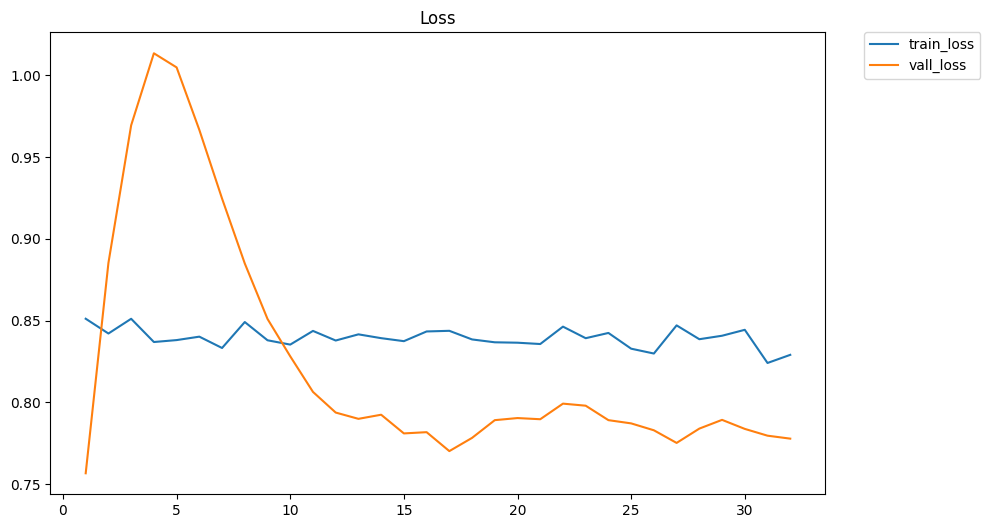

In [360]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train_loss")
plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label="vall_loss")
plt.title("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

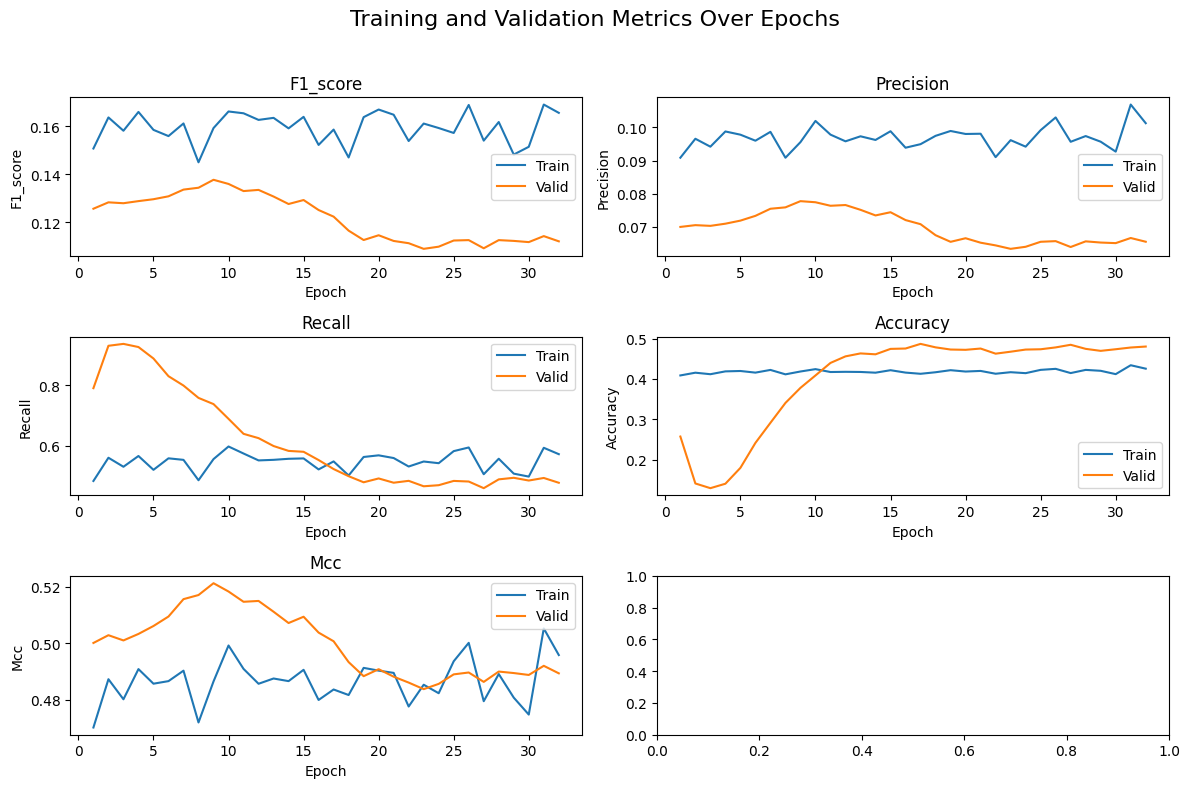

In [361]:
metrics = ['f1_score', 'precision', 'recall', 'accuracy', 'mcc']
epochs = range(1, len(metric_res_train['f1_score']) + 1)
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)
for ax, metric in zip(axes.flatten(), metrics):
    ax.plot(epochs, metric_res_train[metric], label='Train')
    ax.plot(epochs, metric_res_valid[metric], label='Valid')
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [362]:
print(f'best_metrics: {best_metrics}')
print(f'best_loss: {min_loss}')

best_metrics: {'f1_score': 0.12554131199916205, 'precision': 0.06994902963439624, 'recall': 0.7898271779219309, 'accuracy': 0.25698243578275043, 'mcc': 0.5001292328039805}
best_loss: 0.7566075722376505


In [363]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

# Visualizing the model's predictions - Визуализируем предсказания модели

In [364]:
def calculate_metrics(metric_f, masks, predictions):
    pred = torch.sigmoid(predictions)
    f1_score = metric_f.f1_score(masks, pred)
    precision = metric_f.precision(masks, pred)
    recall = metric_f.recall(masks, pred)
    accuracy = metric_f.accuracy(masks, pred)
    mcc = metric_f.matthews_corrcoef(masks, pred)
    return {
        'f1_score': f1_score,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'mcc': mcc
    }


Batch 1
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


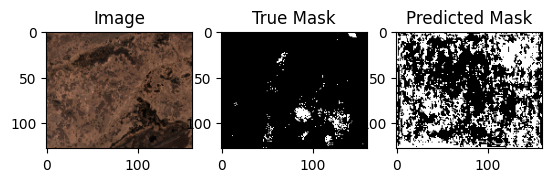

Metrics for Batch 1:
F1 Score: 0.0531
Precision: 0.0287
Recall: 0.3513
Accuracy: 0.5685
MCC: 0.4866
-----------------------------------
Batch 2
Images shape: torch.Size([1, 3, 128, 160])
Masks shape: torch.Size([1, 1, 128, 160])


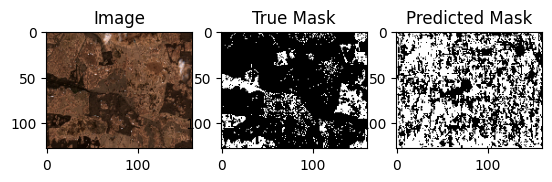

Metrics for Batch 2:
F1 Score: 0.2505
Precision: 0.1610
Recall: 0.5639
Accuracy: 0.4401
MCC: 0.4922
-----------------------------------


In [365]:
# Итерация по датасету и вывод изображений и масок
for batch_idx, (images, masks) in enumerate(valid_dataloader):
    model.eval()
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    with torch.no_grad():
        predictions = model(images.to(device))
    
    # Визуализация изображений и масок
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    mask_true = masks[0].squeeze(0).cpu().numpy()
    pred_mask = torch.round(torch.sigmoid(predictions[0])).cpu().squeeze(0).numpy()

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_true, cmap='gray')
    plt.title("True Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    
    plt.show()
    
    # Подсчет метрик для текущего изображения и маски
    metrics = calculate_metrics(Metrics, torch.tensor(mask_true).unsqueeze(0), torch.tensor(pred_mask).unsqueeze(0))
    
    # Вывод метрик
    print(f'Metrics for Batch {batch_idx + 1}:')
    print(f'F1 Score: {metrics["f1_score"]:.4f}')
    print(f'Precision: {metrics["precision"]:.4f}')
    print(f'Recall: {metrics["recall"]:.4f}')
    print(f'Accuracy: {metrics["accuracy"]:.4f}')
    print(f'MCC: {metrics["mcc"]:.4f}')
    print('-----------------------------------')


C:\Users\Egor\AppData\Local\Temp\ipykernel_21548\4027607438.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Batch 1
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


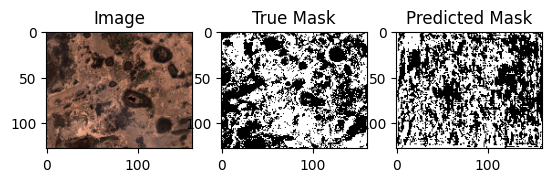

Metrics for Batch 1:
F1 Score: 0.4946
Precision: 0.4967
Recall: 0.4926
Accuracy: 0.4936
MCC: 0.4936
-----------------------------------
Batch 2
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


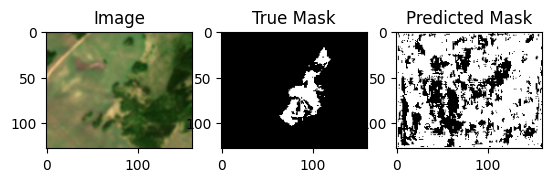

Metrics for Batch 2:
F1 Score: 0.1119
Precision: 0.0611
Recall: 0.6667
Accuracy: 0.3027
MCC: 0.4844
-----------------------------------
Batch 3
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


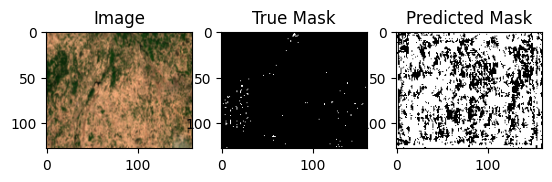

Metrics for Batch 3:
F1 Score: 0.0149
Precision: 0.0075
Recall: 0.7643
Accuracy: 0.3074
MCC: 0.5061
-----------------------------------


In [366]:
# Итерация по датасету и вывод изображений и масок
for batch_idx, (images, masks) in enumerate(train_dataloader):
    model.eval()
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    with torch.no_grad():
        predictions = model(images.to(device))
    
    # Визуализация изображений и масок
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    mask_true = masks[0].squeeze(0).cpu().numpy()
    pred_mask = torch.round(torch.sigmoid(predictions[0])).cpu().squeeze(0).numpy()

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_true, cmap='gray')
    plt.title("True Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    
    plt.show()
    
    # Подсчет метрик для текущего изображения и маски
    metrics = calculate_metrics(Metrics, torch.tensor(mask_true).unsqueeze(0), torch.tensor(pred_mask).unsqueeze(0))
    
    # Вывод метрик
    print(f'Metrics for Batch {batch_idx + 1}:')
    print(f'F1 Score: {metrics["f1_score"]:.4f}')
    print(f'Precision: {metrics["precision"]:.4f}')
    print(f'Recall: {metrics["recall"]:.4f}')
    print(f'Accuracy: {metrics["accuracy"]:.4f}')
    print(f'MCC: {metrics["mcc"]:.4f}')
    print('-----------------------------------')
